In [8]:
# !pip install jsonlines

In [9]:
from pydantic import BaseModel, Field
from enum import Enum
from typing import Optional, List
from openai import OpenAI
from typing import Dict
from tqdm import tqdm
import json
import jsonlines
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


In [10]:
OUTPUT_BENCHMARK = "benchmark_results_Llama-1B_finetuned.json"

In [11]:
client = OpenAI(
    base_url="http://localhost:8001/v1",
    api_key="-",
)
model = client.models.list().data[0].id
model

'/models/trained/Llama-3.2-1B-Instruct_SFT_0.3/checkpoint-1050'

In [12]:
class BugStatus(str, Enum):
    BUG = "True"
    NO_BUG = "False"

class ClassificationResult(BaseModel):
    has_bug: BugStatus
    bugs_free_version: str = Field(default=None, description="Optional fix attempt if model detects a bug - Use it only in case of a bug! else, set null")

json_schema = ClassificationResult.model_json_schema()

In [13]:
def benchmark_openai_structured_model(
    test_data: List[Dict],
    client,
    json_schema: dict,
    output_path: str = None,
    temperature: float = 0.0,
    max_tokens: int = 2056,
    save_every: int = 25,
    start_index: int = 0,
):
    benchmark_results = []

    # Check if output file exists and resume from there
    if output_path and os.path.exists(output_path):
        with open(output_path, "r") as f:
            benchmark_results = json.load(f)
        start_index = len(benchmark_results)
        print(f"Resuming from index {start_index}, loaded {len(benchmark_results)} existing results.")

    for i in tqdm(range(start_index, len(test_data)), desc=f"Benchmarking {model}"):
        entry = test_data[i]
        messages = [m for m in entry["prompt"] if m["role"] != "assistant"]

        try:
            completion = client.chat.completions.create(
                model=model,
                temperature=temperature,
                max_tokens=max_tokens,
                messages=[
                    messages[0], # System message
                    messages[1], # User message
                ],
                # response_format={
                #     "type": "json_schema",
                #     "json_schema": {
                #         "name": "code-diagnostic",
                #         "schema": json_schema
                #     },
                # },
            )

            output_content = completion.choices[0].message.content
            # cleaned_output = re.sub(r"<think>.*?</think>", "", output_content, flags=re.DOTALL)

            benchmark_results.append({
                "index": i,
                "input": messages,
                "output": output_content
            })

        except Exception as e:
            benchmark_results.append({
                "index": i,
                "input": messages,
                "error": str(e)
            })

        # Save progress every `save_every` entries
        if output_path and (i + 1) % save_every == 0:
            with open(output_path, "w") as f:
                json.dump(benchmark_results, f, indent=2)
            

    # Final save
    if output_path:
        with open(output_path, "w") as f:
            json.dump(benchmark_results, f, indent=2)
        print("Final results saved.")

    return benchmark_results

In [14]:
# FIXME - a tmp remove
# os.remove("/home/odedh/SML-For-Debug/benchmark/benchmark_results_Qwen3-0.6B_no_finetunes.json")

with jsonlines.open("/home/odedh/SML-For-Debug/data/dataset/pyresbugs_test.jsonl") as reader:
    test_set = list(reader)

results = benchmark_openai_structured_model(
    test_data=test_set,
    client=client,
    json_schema=json_schema,
    output_path=f"outputs/{OUTPUT_BENCHMARK}",
    save_every=10,
)

Benchmarking /models/trained/Llama-3.2-1B-Instruct_SFT_0.3/checkpoint-1050: 100%|██████████| 1002/1002 [28:52<00:00,  1.73s/it] 

Final results saved.


### Creating the benchmark DF

In [17]:
benchmark_path = f"/home/odedh/SML-For-Debug/benchmark/outputs/{OUTPUT_BENCHMARK}"
dataset_path = "/home/odedh/SML-For-Debug/data/dataset/pyresbugs_test.jsonl"

In [18]:
def robust_tagged_parse(text):
    """
    Parses a model output that includes custom tags such as <BOOL>, <CODE>, <think>, etc.,
    and extracts the structured information based on these tags.
    """
    if not isinstance(text, str):
        return None

    # Extract the <think> section if present
    thinking_match = re.search(r"<think>(.*?)</think>", text, flags=re.DOTALL)
    thinking = thinking_match.group(1).strip() if thinking_match else None
    cleaned = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL)

    # Extract <BOOL>...<BOOL> or <BOOL>... or ...<BOOL>
    bool_match = re.search(r"<BOOL>(.*?)<BOOL>", cleaned)
    if bool_match:
        has_bug = next(filter(None, bool_match.groups()), "").strip()
    else:
        has_bug = None

    # Extract <CODE>...</CODE>, <CODE/>, or <CODE>... end of string
    code_match = re.search(r"<CODE>(.*?)</CODE>|<CODE>(.*)<CODE>", cleaned, flags=re.DOTALL)
    if code_match:
        bugs_free_version = f'<CODE>{next(filter(None, code_match.groups()), "").strip()}<CODE>'
    else:
        bugs_free_version = None

    return {
        "has_bug": has_bug,
        "bugs_free_version": bugs_free_version,
        "thinking": thinking
    }


In [20]:
with open(benchmark_path, "r") as f:
    benchmark_data = json.load(f)

# Load JSONL dataset
dataset = []
with open(dataset_path, "r") as f:
    for line in f:
        dataset.append(json.loads(line))

# Build dataframe
records = []

for entry_gt, entry_model in zip(dataset, benchmark_data):
    # Extract ground truth
    user_msg = next(m for m in entry_gt["prompt"] if m["role"] == "user")
    assistant_msg = next(m for m in entry_gt["completion"] if m["role"] == "assistant")
    source_code = str(user_msg["content"])
    prompt = entry_gt["prompt"][0]["content"]

    try:
        gt_response = json.loads(assistant_msg["content"])
        gt_is_buggy = 'true' in gt_response['has_bug'].lower()
        gt_fix = gt_response.get("Code", None)
    except Exception:
        gt_is_buggy = None
        gt_fix = None
        gt_acronym = None

    # Extract model output
    try:
        model_output = robust_tagged_parse(entry_model["output"])
        model_is_buggy = "true" in model_output.get("has_bug", "").lower()
        model_fix = model_output.get("bugs_free_version", None)
        model_thinking = model_output.get("thinking", None)
    except Exception as e:
        model_is_buggy = None
        model_fix = None
        model_thinking = None

    records.append({
        "input_prompt": prompt.strip(),
        "source_code": source_code.strip(),
        "ground_truth_is_buggy": gt_is_buggy,
        "ground_truth_fix": gt_fix,
        "model_is_buggy": model_is_buggy,
        "model_suggested_fix": model_fix,
        "model_thinking": model_thinking,
    })

df = pd.DataFrame(records)
df


,input_prompt,source_code,ground_truth_is_buggy,ground_truth_fix,model_is_buggy,model_suggested_fix,model_thinking
0,You are a code analysis model. Your task is to...,"def __init__(\n self,\n database...",False,"<CODE>def __init__(\n self,\n da...",True,"<CODE>def __init__(\\n self,\\n ...",None
1,You are a code analysis model. Your task is to...,"def uuid3(namespace, name):\n from hashlib ...",True,"<CODE>def uuid3(namespace, name):\n from ha...",True,"<CODE>def uuid3(namespace, name):\\n from h...",None
2,You are a code analysis model. Your task is to...,"def cascaded_union(self):\n ""Returns a ...",False,"<CODE>def cascaded_union(self):\n ""Retu...",True,"<CODE>def cascaded_union(self):\\n \""Re...",None
3,You are a code analysis model. Your task is to...,"def _copy(master_fd, master_read=_read, stdin_...",False,"<CODE>def _copy(master_fd, master_read=_read, ...",True,"<CODE>def _copy(master_fd, master_read=_read, ...",None
4,You are a code analysis model. Your task is to...,def __str__(self):\n template = '(NOT (...,False,<CODE>def __str__(self):\n template = '...,True,<CODE>def __str__(self):\\n template = ...,None
...,...,...,...,...,...,...,...
997,You are a code analysis model. Your task is to...,"def strip_entities(value):\n ""Returns the g...",False,"<CODE>def strip_entities(value):\n ""Returns...",True,"<CODE>def strip_entities(value):\\n \""Retur...",None
998,You are a code analysis model. Your task is to...,"def _safe_ParseResult(parts, encoding='utf8', ...",False,"<CODE>def _safe_ParseResult(parts, encoding='u...",True,"<CODE>def _safe_ParseResult(parts, encoding='u...",None
999,You are a code analysis model. Your task is to...,"def renew_from_kt(principal, keytab):\n ren...",False,"<CODE>def renew_from_kt(principal, keytab):\n ...",True,"<CODE>def renew_from_kt(principal, keytab):\\n...",None
1000,You are a code analysis model. Your task is to...,"def _get_field(self, field_name: str):\n ...",False,"<CODE>def _get_field(self, field_name: str):\n...",True,"<CODE>def _get_field(self, field_name: str):\\...",None


### EDA

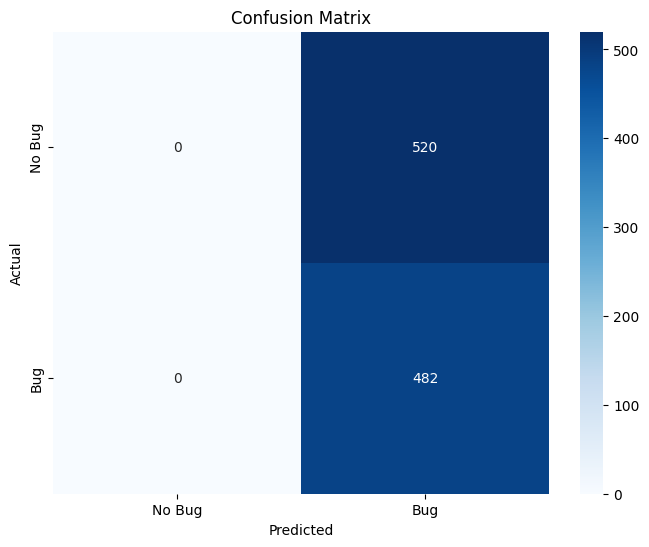

{'precision': 0.4810379241516966,
 'recall': 1.0,
 'f1_score': 0.6495956873315364,
 'confusion_matrix': [[0, 520], [0, 482]],
 'total_samples': 1002}

In [21]:
# Filter rows where model prediction exists and ground truth is defined
valid_df = df[df["model_is_buggy"].notnull(
) & df["ground_truth_is_buggy"].notnull()]

# Ensure both are booleans
y_true = valid_df["ground_truth_is_buggy"].astype(bool)
y_pred = valid_df["model_is_buggy"].astype(bool)

# Basic classification metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# plot the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Bug", "Bug"], yticklabels=["No Bug", "Bug"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Return all to user
{
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "confusion_matrix": conf_matrix.tolist(),
    "total_samples": len(valid_df)
}